# Grid Cell Phase Coding 

"Phases are in radians, coordinates are in [m] and time base is [ms]. The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value"

After changing parameters in the second cell, from the top menu click 'Cell' -> 'Run All' then scroll through

(TODO: add firing map (#spikes/time), variance as lightness in meanphasemap (pi), variance weighting, amount of spikes vs. correlation, temporal separation of spikes vs. correlation, radial distribution of prediction variance, population vector prediction,
low variance phase map?)

(note whether coordinates in numpy [-y,x] or Cartesian [x,y])

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
from scipy.stats import pearsonr
import pycircstat
from scipy import ndimage

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

In [2]:
allspikes = np.loadtxt('SpikePhaseData.csv', delimiter='\t')

#Splitting all spike-rows to divide the set 50% for the analysis and 50% for the mean phase map generation
evens = allspikes[::2,:]
odds = allspikes[1::2,:]

#Spatial or temporal analysis
analysis_type = 'temporal'

## XYspkT

XYspkT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

XYspkT is float values, can be converted to integer with np.round(scaled_XY) as the coarse spatial analysis from the adjacency matrix only results in integer movement predictions

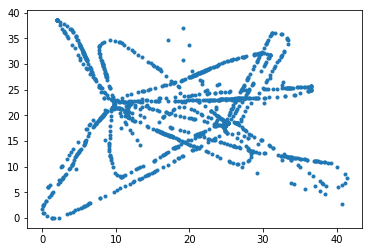

In [3]:
XYspkT = evens[:,2:]

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

plt.plot(scaled_XY[:,0],scaled_XY[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [4]:
spkT = evens[:,0]
print(spkT)
spkT.shape

[   443.    593.   1166. ... 282430. 284230. 295580.]


(1254,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at the moment of spike

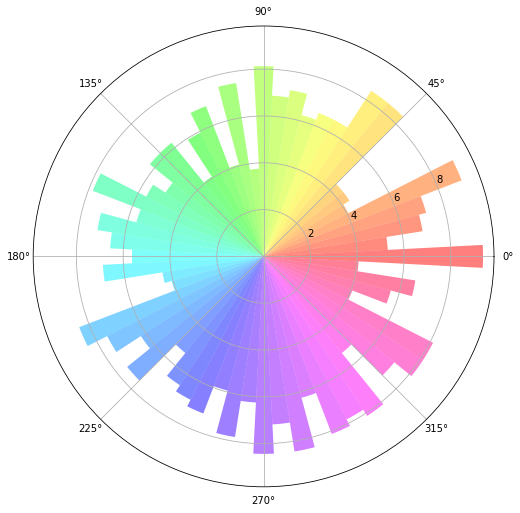

In [5]:
#phase = evens[:,1]
phase = np.random.rand(spkT.size)*6.28
scaled_phase = phase-3.14

phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

TODO:

-(time based meanphasemap of first half, traj from second)

-average internode distance

C:\ProgramData\Anaconda3\lib\site-packages\pycircstat\descriptive.py:340: RuntimeWarning: invalid value encountered in cdouble_scalars
  np.sum(w, axis=axis))
C:\ProgramData\Anaconda3\lib\site-packages\pycircstat\decorators.py:31: RuntimeWarning: invalid value encountered in double_scalars
  return ret % (2 * np.pi)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


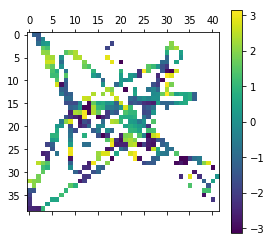

In [6]:
def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = pycircstat.mean(np.asarray(phases))

    #Rotate the dataframe 90 CCW
    mpm = pd.DataFrame.from_dict(mpm_dict).T
    phase_df = mpm.reindex(index=mpm.index[::-1])-3.14
    
    #(Uniform) Smoothing algorithm
    #Replaces each value with circular mean of (inclusive) neighbouring 3x3 matrix
    np_dfp = np.pad(phase_df.as_matrix(), 1, 'constant', constant_values=np.nan)
    a = np.zeros((np_dfp.shape[0], np_dfp.shape[1]))

    for i in range(len(np_dfp)-2):
        for j in range(len(np_dfp[i])-2):
            arr = np_dfp[i:i+3,j:j+3]
            if not np.isnan(arr[1,1]):
                n_arr = arr[~np.isnan(arr)]
                avg = pycircstat.mean(n_arr)
                a[i+1,j+1] = avg

    a[a==0]=np.nan
    a = a[1:-1,1:-1]-3.14
    phase_df = pd.DataFrame(a)
    
    return phase_df

XY_odds = odds[:,2:]
XY_odds[:,1] -= XY_odds[:,1].min()
XY_odds[:,0] -= XY_odds[:,0].min()

mpm_arr = np.column_stack((XY_odds,odds[:,1]))
phase_df = mean_phase_map(mpm_arr,2)
arena_size = phase_df.shape


plt.matshow(phase_df)

#To-do: reflect radians in bar
plt.colorbar()

## Phase Variance Map

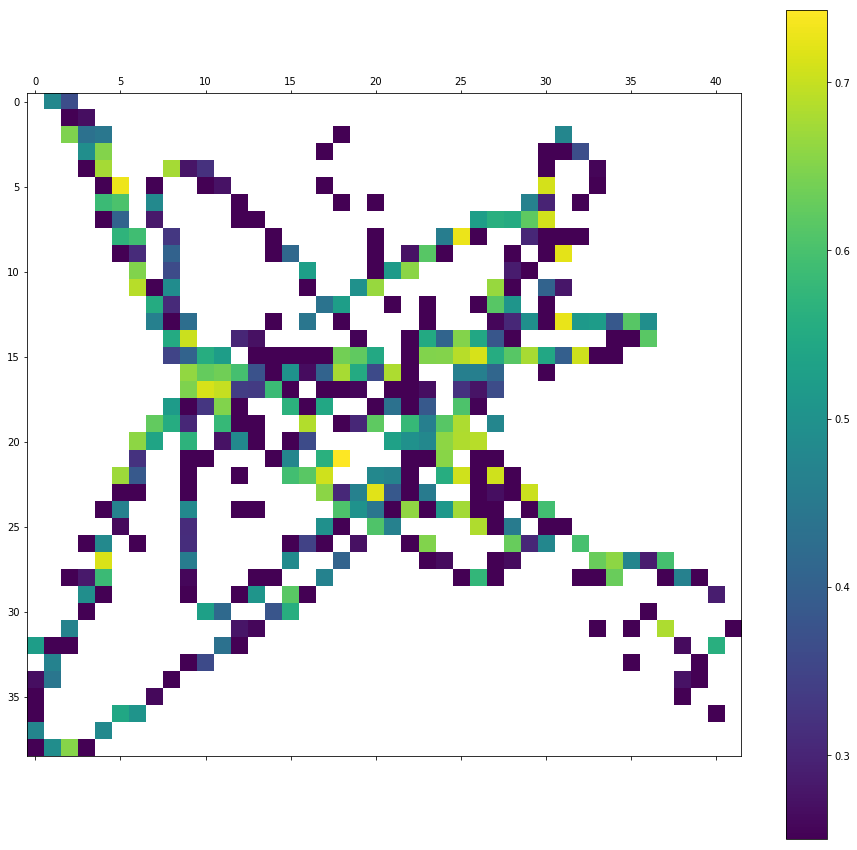

In [98]:
def var_map(arr, bin_size):
    """Bins data in a 2x2 matrix to the phase variance"""
    vm_dict = {}
    for ybin in range(0, int(allspikes[:, 3].max() + 1), bin_size):
        vm_dict[ybin] = {}
        for xbin in range(0, int(allspikes[:, 2].max() + 1), bin_size):
            phases = []
            vm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin + bin_size) and (ybin <= spike[1] <= ybin + bin_size):
                    phases.append(spike[2])
            vm_dict[ybin][xbin] = (pycircstat.var(np.asarray(phases))+0.5)/2

    #Rotate the dataframe 90 CCW
    vm = pd.DataFrame.from_dict(vm_dict).T
    var_df = vm.reindex(index=vm.index[::-1])

    return var_df

# Generate mean phase map
vm_arr = np.column_stack((XY_odds, odds[:,1]))
var_df = var_map(vm_arr, 2)

plt.matshow(var_df)

#To-do: reflect radians in bar
plt.colorbar()

## Phase Variance Map

In [8]:
xyPos = np.loadtxt(dir+'xyPos.csv',delimiter=',')[::25]
xyPos[:,1]-= xyPos[:,1].min()
xyPos[:,0]-= xyPos[:,0].min()
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=6)

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

In [129]:
def adjacent_spikes(spikes, phase):
    """Get location of spike with most similar phase"""
    y_size = arena_size[0] - 1
    phases = []
    vars = []
    
    for i in spikes:
        
        x = int(i[0])
        if x >= arena_size[1]:
            x -= 1

        y = int(i[1])
        if y >= arena_size[0]:
            y -= 1
            
        phases.append(phase_df.iloc[y_size - y, x])
        vars.append(var_df.iloc[y_size - y, x])
        
    #KNN-like approach - MESSY
#     if spikes.shape[0]>1:
#         for i in range(spikes.shape[0]):
#             if i-1<0:
#                 cluster = [np.nan, spikes[i], spikes[i+1]]
#             elif i+1==len(spikes):
#                 cluster = [spikes[i-1], spikes[i], np.nan]
#             else:
#                 cluster = spikes[i-1:i+2]


#             clust_phases = []
#             for j in cluster:
#                 if not np.any(np.isnan(j)):

#                     x = int(j[0])
#                     if x >= arena_size[1]:
#                         x -= 1

#                     y = int(j[1])
#                     if y >= arena_size[0]:
#                         y -= 1

#                     clust_phases.append(phase_df.iloc[y_size - y, x])


#                 phases.append(pycircstat.mean(clust_phases))
#     else:
#         print('test')
#         x = int(spikes[0][0])
#         if x >= arena_size[1]:
#             x -= 1

#         y = int(spikes[0][1])
#         if y >= arena_size[0]:
#             y -= 1
#         phases.append(phase_df.iloc[y_size - y, x])
            
    phases = np.asarray(phases)
    vars = np.asarray(vars)
    diffs = np.abs(phases - phase)*vars
    
    try:
        nearest = np.nanargmin(diffs)
        #nearest = np.nanargmin(np.abs(phases - phase))
    except:
        nearest = 0

    try:
        #Rounding down to the nearest bin, adding 0.5 to point to center of bin
        x = int(spikes[nearest][0])+0.5 
        y = int(spikes[nearest][1])+0.5
        return [x - spikes[0, 0], y - spikes[0, 1]]

    except:
        return [0.0, 0.0]
    
    
#Tests:
#print(adjacent_matrix([3,0.5],-1.5))
#adjacent_spikes(combined[10:16,1:3],combined[10,4])

## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [130]:
unsorted = np.column_stack((spkT,scaled_XY,scaled_phase))
sorted = unsorted[unsorted[:,0].argsort()]

#Calculate movement magnitudes
xdif = np.append(sorted[1:,1],0)-np.append(sorted[:-1,1],0)
ydif = np.append(sorted[1:,2],0)-np.append(sorted[:-1,2],0)

#Drop rows with movements below threshold
move_thresh = 0.01

raw = np.column_stack((sorted,xdif,ydif))
print(raw)
movement  = raw[np.any(abs(raw[:,4:]) >= move_thresh, axis=1)]

#Recalculate movement magnitudes
xdif = np.append(movement[1:,1],0)-np.append(movement[:-1,1],0)
ydif = np.append(movement[1:,2],0)-np.append(movement[:-1,2],0)
next_phase = np.insert(movement[1:,3],-1, 0)

combined = np.column_stack((movement[:,:4],next_phase,xdif,ydif))
print(combined)

[[    80.             16.41015        19.6108          2.21191121
       0.              0.        ]
 [   443.             16.41015        19.6108          2.49783807
       0.              0.        ]
 [   593.             16.41015        19.6108         -2.41586716
       0.15035         0.261     ]
 ...
 [297930.             24.92435        22.88245         2.80302425
       0.9113          0.05065   ]
 [298300.             25.83565        22.9331          2.08666002
       0.89935         0.05      ]
 [298660.             26.735          22.9831          2.15881423
       0.              0.        ]]
[[   593.             16.41015        19.6108     ...      2.59612573
       0.15035         0.261     ]
 [  1166.             16.5605         19.8718     ...      1.31514715
       1.2196          1.2141    ]
 [  1873.             17.7801         21.0859     ...     -0.34324617
       0.1634          0.14305   ]
 ...
 [297020.             22.6056         22.7536     ...      2.8030242

In [131]:
# Spatial Analysis
if analysis_type == 'spatial':
    predicted = [adjacent_matrix([i[1],i[2]],i[4]) for i in combined]
    predicted_movement = np.asarray(predicted)

# Temporal Analysis    
if analysis_type == 'temporal':
    diff = int(len(spkT)/100)
    if diff<5:
        diff=5
    predicted = [adjacent_spikes(combined[i:i+diff,1:3],combined[i,4]) for i in range(len(combined))]
    predicted_movement = np.asarray(predicted)
    
all=np.column_stack((combined,predicted_movement))
df = pd.DataFrame(data=all, columns=['Time','X','Y','Phase','Next Phase','Xdif','Ydif','Xdif Predicted', 'Ydif Predicted'])

df

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted
0,593.0,16.410150,19.610800,-2.415867,2.596126,0.150350,0.261000,5.089850,0.889200
1,1166.0,16.560500,19.871800,2.596126,1.315147,1.219600,1.214100,4.939500,0.628200
2,1873.0,17.780100,21.085900,1.315147,-0.343246,0.163400,0.143050,0.719900,0.414100
3,1960.0,17.943500,21.228950,-0.343246,-2.018195,0.590000,0.323200,-0.443500,0.271050
4,2232.0,18.533500,21.552150,-2.018195,2.477935,0.675300,0.082150,2.966500,-1.052150
5,2507.0,19.208800,21.634300,2.477935,0.571071,1.068250,-0.378900,5.291200,-4.134300
6,2966.0,20.277050,21.255400,0.571071,-0.789779,0.339170,-0.215350,2.222950,-1.755400
7,3128.0,20.616220,21.040050,-0.789779,-0.337983,0.419400,-0.403945,4.883780,-2.540050
8,3362.0,21.035620,20.636105,-0.337983,1.661715,0.478680,-0.456645,0.464380,-0.136105
9,3628.0,21.514300,20.179460,1.661715,2.203998,0.181550,-0.122975,-0.014300,0.320540


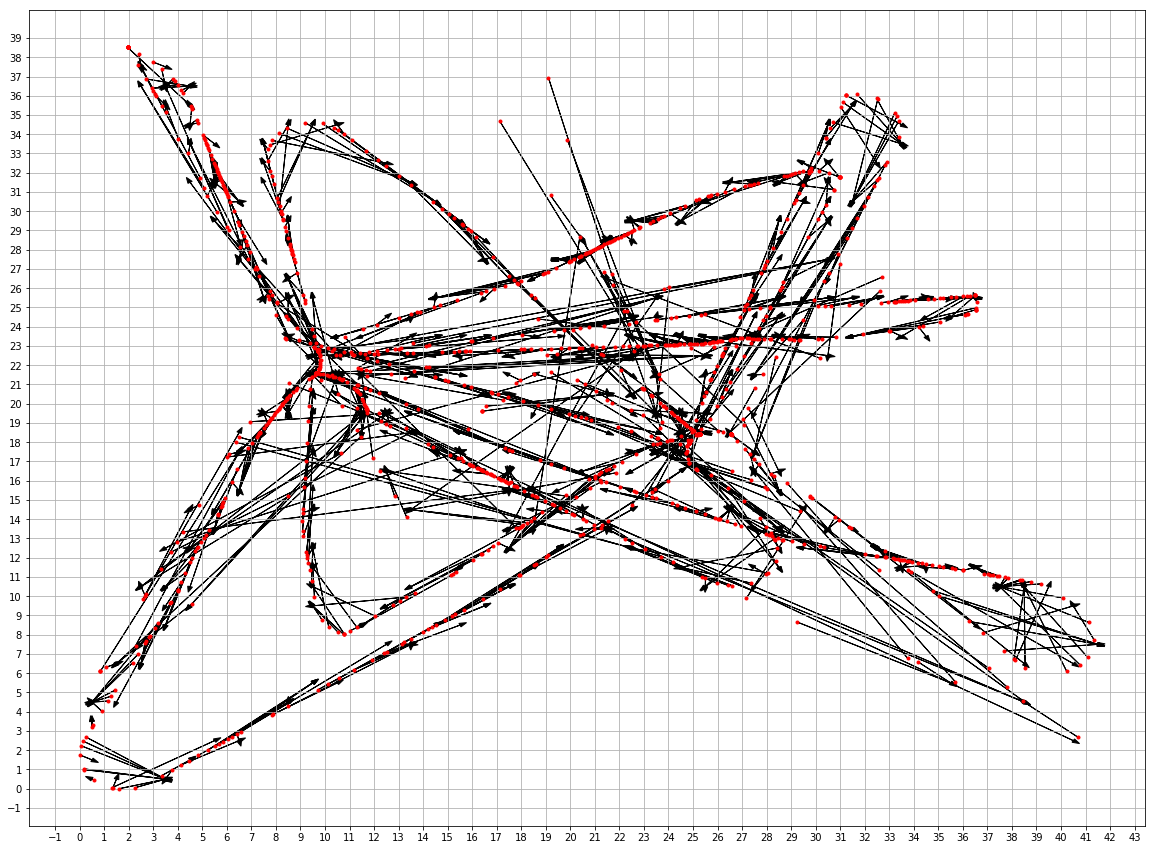

In [132]:
plt.rcParams['figure.figsize'] = [20, 15]
ax = plt.subplot()
#plt.plot(xyPos[:,0]/2, xyPos[:,1]/2, color='b')
plt.plot(scaled_XY[:,0], scaled_XY[:,1], '.', color='r', markersize=6)
for index, row in df.iterrows():
    # if (row['Xdif Predicted']>0) or (row['Ydif Predicted']>0):
    plt.arrow(row['X'], row['Y'], row['Xdif Predicted'], row['Ydif Predicted'],
                head_width=0.2, color='black')

ax.set_xticks(np.arange(scaled_XY[:,0].min()-1,scaled_XY[:,0].max()+2))
ax.set_yticks(np.arange(scaled_XY[:,1].min()-1,scaled_XY[:,1].max()+1))
ax.grid()

## Vector Angles

Calculates the angle between each movements observed and predicted vector angle to store in a list for use
in the correlation figures

In [133]:
#Determines the angle between the horizontal axis (+1 x, +0 y) and the current vector, returns [observed,predicted]
def abs_vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1],all[i+1,2]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            obs_angles.append(360+np.degrees(atan))
        else:
            obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i,1]+all[i,7],all[i,2]+all[i,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            pred_angles.append(360+np.degrees(atan))
        else:
            pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))


In [135]:
angles = np.asarray(abs_vector_angles(all))

print('Linear r correlation : ' + str(pearsonr(angles[:,0],angles[:,1])[0]))
print('Circular r correlation: ' + str(pycircstat.corrcc(np.radians(angles[:,0]),np.radians(angles[:,1]))))

Linear r correlation : 0.5928144764822179
Circular r correlation: 0.65238839439041


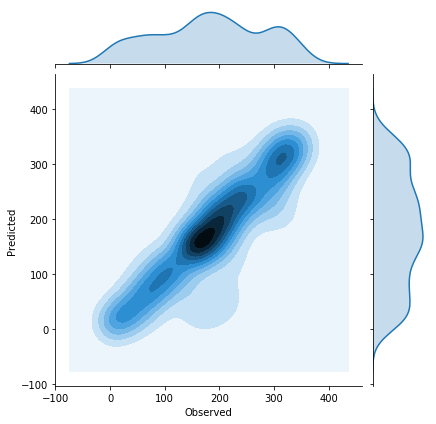

In [127]:
dfa = pd.DataFrame(angles, columns=['Observed', 'Predicted'])
sns.jointplot(x='Observed',y='Predicted',data=dfa,kind='kde');

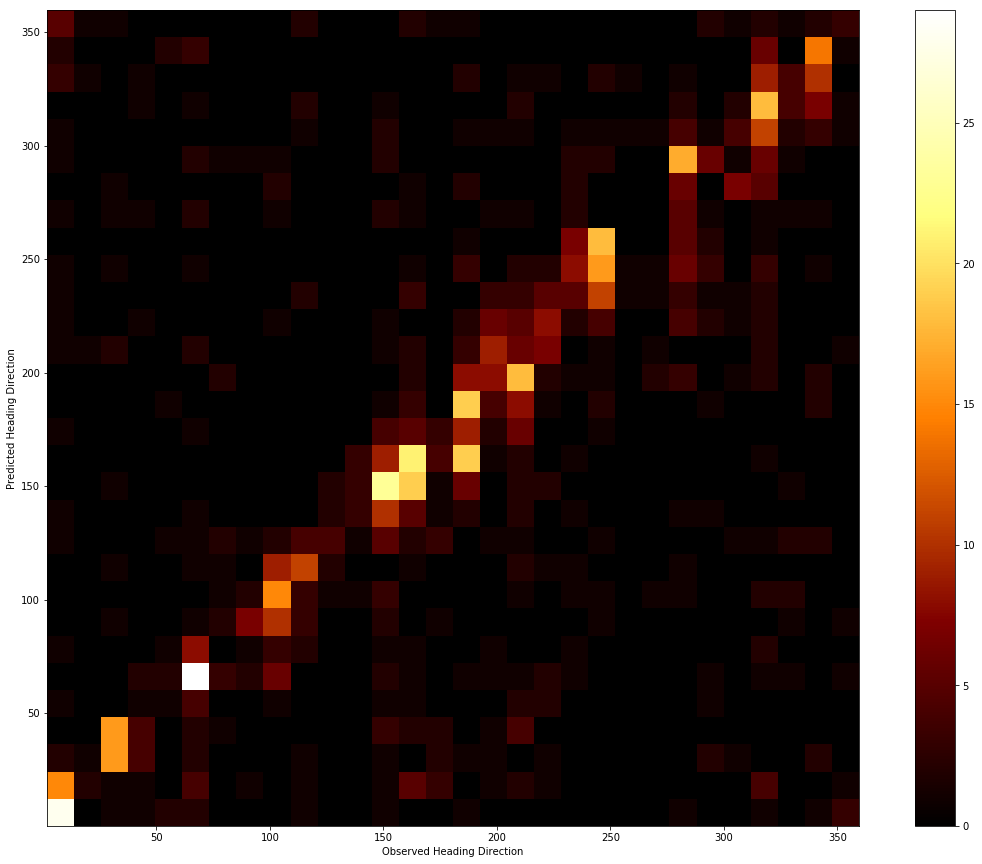

In [128]:
heatmap, xedges, yedges = np.histogram2d(angles[:,0], angles[:,1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='afmhot')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

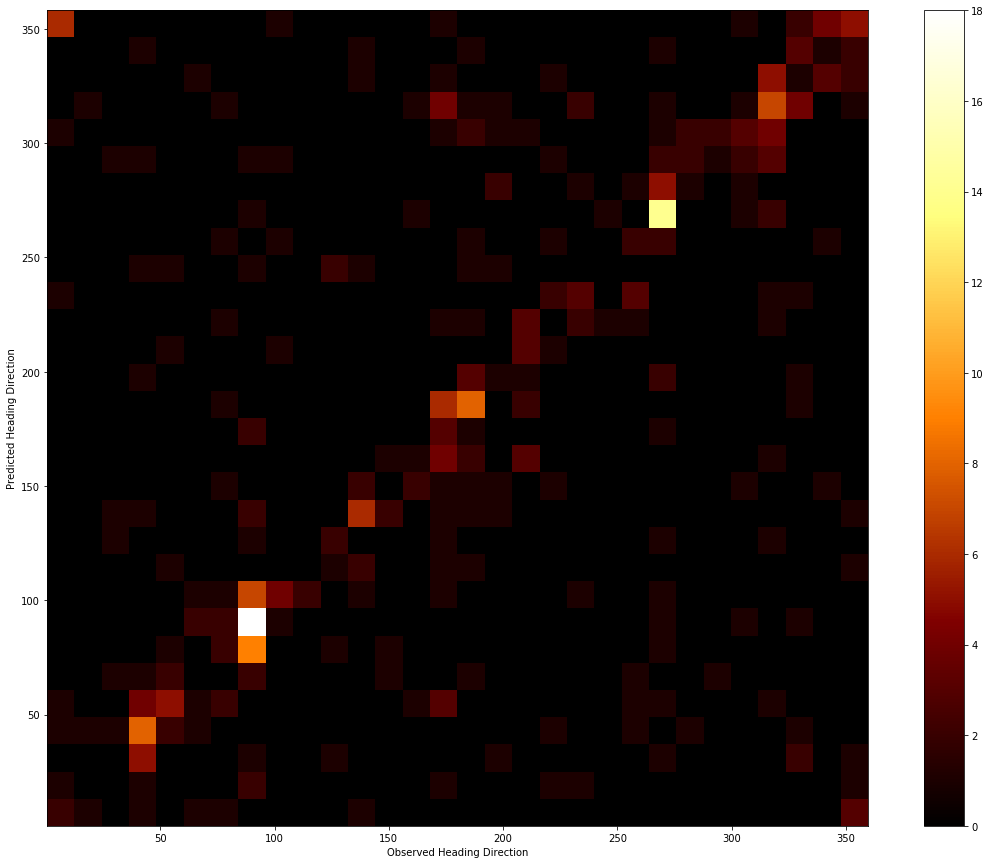

In [176]:
heatmap2, xedges, yedges = np.histogram2d(angles[:,0], angles[:,1], bins=30)
extent2 = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap2.T, extent=extent, origin='lower',cmap='afmhot')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

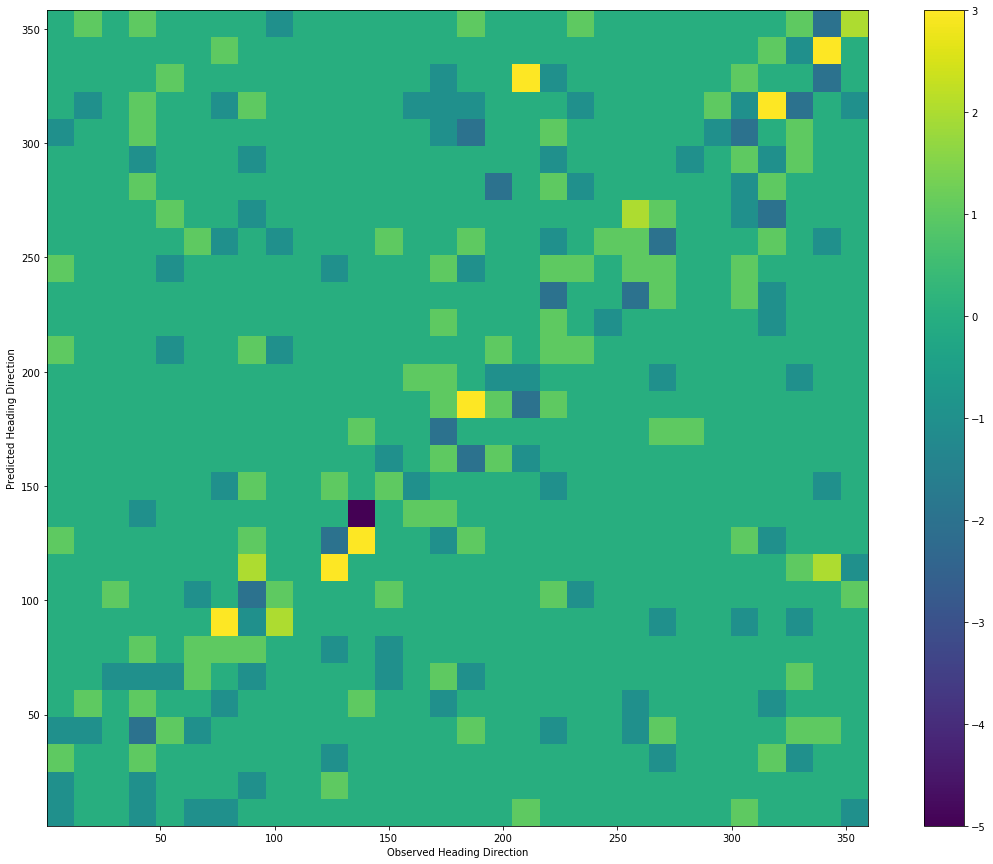

In [177]:
test = heatmap.T-heatmap2.T

plt.clf()
plt.imshow(test, extent=extent, origin='lower')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

## Testing Area

Sandbox for developing new features

In [ ]:
diff = np.sort(angles[:,0]-angles[:,1])

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(diff.min(),diff.max()+6,6))

inds = [np.where(diff<i)[0][-1] for i in np.arange(diff.min()+6,diff.max()+6,6)] #vectorize operation?
b = np.split(diff,inds)
radii = np.array([i.size for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

In [115]:
for i in range(len(combined)):
    print(i)
    print(adjacent_spikes(combined[i:i+diff,1:3],combined[i,4]))


0


ValueError: operands could not be broadcast together with shapes (8,) (0,) 

In [114]:
int(combined[1123])

TypeError: only size-1 arrays can be converted to Python scalars

In [66]:
combined[1123:1130,1:3][0][0]

25.83565

In [154]:
unsorted[374]

array([170190.     ,     16.55895,     12.094  ,      0.4021 ])

In [47]:
arena_size[1]

23

In [48]:
23.0075>arena_size[1]

True

In [64]:
phase_df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-2.923816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.534737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.906160,NaN,NaN,NaN
2,-1.697299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.338147,1.305136,1.482000,NaN,1.569457,NaN,NaN,NaN
3,-1.379418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.199304,-1.147857,-0.188515,-0.234650,0.980869,0.753501,NaN,NaN,NaN
4,1.381331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.990448,-2.025041,-2.421085,-1.316882,-2.177685,NaN,2.279875,NaN,-1.286925
5,2.368360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.136286,-1.353078,-1.692445,NaN,NaN,2.628396,NaN,NaN,-2.020238
6,2.182964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.561558,-1.514258,NaN,-0.714544,NaN,-2.612752,-2.674058,-2.502464,NaN
7,-0.623910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.301808,0.252643,0.224913,NaN,1.358708,2.032480,-2.859865,-2.825812,-2.760561,NaN
8,1.116426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.179491,NaN,-1.742094,NaN,NaN,-1.134179,NaN,NaN,2.691025,NaN
9,0.547450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.037440,1.292650,...,NaN,NaN,3.037965,NaN,-2.258004,-2.499864,2.777454,NaN,1.405899,NaN
